In [1]:
import torch
import torch.nn as nn
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
from torchvision import datasets
from torchsummary import summary
from torch.utils.data import random_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from torchvision import transforms
from PIL import Image
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:

import numpy as np

from shutil import copyfile
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

In [5]:
def train_val_test_dataset(dataset, val_split=0.3,test_split=0.1,random_seed=None):
    amount = len(dataset)

    test_amount = (
        int(amount * test_split)
        if test_split is not None else 0)
    val_amount = (
        int(amount * val_split)
        if val_split is not None else 0)
    train_amount = amount - test_amount - val_amount

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        (train_amount, val_amount, test_amount),
        generator=(
            torch.Generator().manual_seed(random_seed)
            if random_seed
            else None))
    
    return train_dataset, val_dataset, test_dataset

In [46]:
dataset = ImageFolder('E:\skripsi\koding skrip\hasil\per_city\malang', transform=Compose([Resize((224,224)),ToTensor()]))
print(len(dataset))
train,valid,test = train_val_test_dataset(dataset)
print(len(train))
print(len(valid))
print(len(test))
# The original dataset is available in the Subset class

train_dataloaders = DataLoader(train,32, shuffle=True, num_workers=4)
test_dataloaders = DataLoader(test,32, shuffle=True, num_workers=4)
valid_dataloaders = DataLoader(valid,32, shuffle=True, num_workers=4)
print(torch.is_tensor(dataset))

4615
2770
1384
461
False


In [7]:
class CNNet(nn.Module):
    def __init__(self, numChannels, classes):
        # call the parent constructor
        super(CNNet, self).__init__()
        # initialize first set of CONV => RELU => POOL layers
        self.block1 = nn.Sequential(nn.Conv2d(in_channels=numChannels, out_channels=20,
            kernel_size=(5, 5)),nn.ReLU(),nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
        self.block2 = nn.Sequential(nn.Conv2d(in_channels=20, out_channels=50,
            kernel_size=(5, 5)),nn.ReLU(),nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
        self.block3 =nn.Sequential(nn.Linear(in_features=140450, out_features=300),nn.ReLU(),nn.Linear(in_features=300, out_features=classes))
        #self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20,kernel_size=(5, 5))
        #self.relu1 = nn.ReLU()
        #self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize second set of CONV => RELU => POOL layers
        #self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,kernel_size=(5, 5))
        #self.relu2 = nn.ReLU()
        #self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=140450, out_features=300)
        self.relu3 = nn.ReLU()
        # initialize our softmax classifier
        self.fc2 = nn.Linear(in_features=300, out_features=classes)
        

   

    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        #x = self.conv1(x)
        #x = self.relu1(x)
        #x = self.maxpool1(x)
        x = self.block1(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        #x = self.conv2(x)
        #x = self.relu2(x)
        #x = self.maxpool2(x)
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = self.block2(x)
        x = torch.flatten(x, 1)
        
        #x = self.fc1(x)
        #x = self.relu3(x)
        # pass the output to our softmax classifier to get our output
        # predictions
        output = self.block3(x)
        #output = self.logSoftmax(x)
        # return the output predictions
        return output
    
    
    


In [41]:
model = CNNet(numChannels=3,
	classes=len(train.dataset.classes)).to(device)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  

# Train the model
#total_step = len(train_dataloaders)

In [9]:
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 20, 110, 110]        --
|    └─Conv2d: 2-1                       [-1, 20, 220, 220]        1,520
|    └─ReLU: 2-2                         [-1, 20, 220, 220]        --
|    └─MaxPool2d: 2-3                    [-1, 20, 110, 110]        --
├─Sequential: 1-2                        [-1, 50, 53, 53]          --
|    └─Conv2d: 2-4                       [-1, 50, 106, 106]        25,050
|    └─ReLU: 2-5                         [-1, 50, 106, 106]        --
|    └─MaxPool2d: 2-6                    [-1, 50, 53, 53]          --
├─Sequential: 1-3                        [-1, 4]                   --
|    └─Linear: 2-7                       [-1, 300]                 42,135,300
|    └─ReLU: 2-8                         [-1, 300]                 --
|    └─Linear: 2-9                       [-1, 4]                   1,204
Total params: 42,163,074
Trainable params: 42,163,074
Non-trainable

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 20, 110, 110]        --
|    └─Conv2d: 2-1                       [-1, 20, 220, 220]        1,520
|    └─ReLU: 2-2                         [-1, 20, 220, 220]        --
|    └─MaxPool2d: 2-3                    [-1, 20, 110, 110]        --
├─Sequential: 1-2                        [-1, 50, 53, 53]          --
|    └─Conv2d: 2-4                       [-1, 50, 106, 106]        25,050
|    └─ReLU: 2-5                         [-1, 50, 106, 106]        --
|    └─MaxPool2d: 2-6                    [-1, 50, 53, 53]          --
├─Sequential: 1-3                        [-1, 4]                   --
|    └─Linear: 2-7                       [-1, 300]                 42,135,300
|    └─ReLU: 2-8                         [-1, 300]                 --
|    └─Linear: 2-9                       [-1, 4]                   1,204
Total params: 42,163,074
Trainable params: 42,163,074
Non-trainable

TRAIN THE MODEL

In [47]:
num_classes = 4
num_epochs = 15
batch_size = 16
train_loader = train_dataloaders
valid_loader = valid_dataloaders

In [11]:
import gc
import time
total_step = len(train_loader)
total_start_time = time.time()
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        losse = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        losse.backward()
        optimizer.step()
        running_loss = losse.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct / total}%')
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss2 = criterion(outputs, labels)
            val_loss = loss2.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            del images, labels, outputs
    
        print(f'Validation Loss: {val_loss/len(valid_loader)}, Validation Accuracy: {100 * correct / total}%')
total_end_time = time.time()
total_duration = total_end_time - total_start_time
print(f'Total training time: {total_duration:.2f} seconds')
torch.save(model.state_dict(), 'model15.pth') 

Epoch [1/15], Loss: 4.493735711245487e-07, Accuracy: 93.90225676281572%
Validation Loss: 3.09698571938844e-05, Validation Accuracy: 99.79073243647235%
Epoch [2/15], Loss: 6.5914748813070005e-06, Accuracy: 99.73098191600657%
Validation Loss: 0.00032872046743120465, Validation Accuracy: 99.91031390134529%
Epoch [3/15], Loss: 1.7441875700439726e-06, Accuracy: 99.85054550889254%
Validation Loss: 2.901826242339753e-06, Validation Accuracy: 99.94020926756353%
Epoch [4/15], Loss: 3.823444768342944e-06, Accuracy: 99.92527275444627%
Validation Loss: 3.3280898129478805e-06, Validation Accuracy: 100.0%
Epoch [5/15], Loss: 5.922577959912208e-08, Accuracy: 99.88043640711403%
Validation Loss: 4.185839567244763e-06, Validation Accuracy: 100.0%
Epoch [6/15], Loss: 7.129177185041563e-05, Accuracy: 99.98505455088926%
Validation Loss: 1.7863416966671744e-06, Validation Accuracy: 100.0%
Epoch [7/15], Loss: 6.265264181863694e-06, Accuracy: 99.91032730533553%
Validation Loss: 1.4976292316402707e-05, Validat

In [12]:
torch.save(model.state_dict(), 'E:\skripsi\koding skrip\hasil\model.pth') 

FASE PENGUJIAN

In [15]:
test_loader = test_dataloaders

In [16]:
with torch.no_grad():
    prediction = []
    labeling = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
       
        probabilities = torch.exp(outputs)
        prediction += probabilities.max(dim=1)[1].tolist()
        labeling += labels.tolist()
        
        
        del images, labels, outputs

    #print('Accuracy of the network on the {} test images: {} %'.format(1124, 100 * correct / total))
print(classification_report(labeling, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00       418
           2       1.00      1.00      1.00       179
           3       1.00      1.00      1.00       410

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115



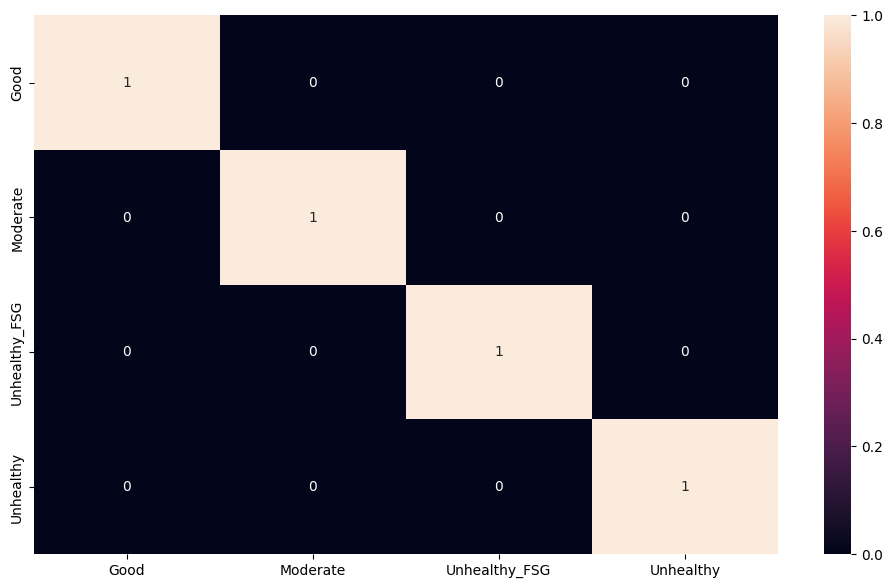

In [17]:

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Good', 'Moderate', 'Unhealthy_FSG','Unhealthy')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size used during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and transform the image
img_path = 'path_to_your_image.jpg'  # Replace with the path to your image
image = Image.open(img_path)
image = transform(image)
image = image.unsqueeze(0)  # Add batch dimension
# If you want the class with the highest probability
_, predicted_class = torch.max(output, 1)

print(f'Predicted class: {predicted_class.item()}')

K-FOLD CROSS VALIDATION


In [48]:

from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

# Parameters
num_epochs = 15
num_folds = 5
batch_size = 32
learning_rate = 0.001

In [49]:
kf = KFold(n_splits=num_folds, shuffle=True)
fold_results = {}

# K-Fold Cross Validation model evaluation
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold + 1}')
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = CNNet(numChannels=3,
	classes=len(train.dataset.classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  

    # Training
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_subset)
        print(f'Epoch {epoch + 1} of {num_epochs}, Fold {fold + 1}, Training Loss: {epoch_loss:.4f}')

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        fold_accuracy = 100 * correct / total
        fold_results[fold + 1] = fold_accuracy
        print(f'Validation Accuracy for fold {fold + 1}: {fold_accuracy:.2f}%')

# Average results from all folds
average_accuracy = sum(fold_results.values()) / num_folds
print(f'Average Accuracy: {average_accuracy:.2f}%')

Fold 1
Epoch 1 of 15, Fold 1, Training Loss: 0.1580
Epoch 2 of 15, Fold 1, Training Loss: 0.0176
Epoch 3 of 15, Fold 1, Training Loss: 0.0055
Epoch 4 of 15, Fold 1, Training Loss: 0.0049
Epoch 5 of 15, Fold 1, Training Loss: 0.0044
Epoch 6 of 15, Fold 1, Training Loss: 0.0030
Epoch 7 of 15, Fold 1, Training Loss: 0.0032
Epoch 8 of 15, Fold 1, Training Loss: 0.0039
Epoch 9 of 15, Fold 1, Training Loss: 0.0022
Epoch 10 of 15, Fold 1, Training Loss: 0.0026
Epoch 11 of 15, Fold 1, Training Loss: 0.0019
Epoch 12 of 15, Fold 1, Training Loss: 0.0026
Epoch 13 of 15, Fold 1, Training Loss: 0.0028
Epoch 14 of 15, Fold 1, Training Loss: 0.0016
Epoch 15 of 15, Fold 1, Training Loss: 0.0023
Validation Accuracy for fold 1: 100.00%
Fold 2
Epoch 1 of 15, Fold 2, Training Loss: 0.1882
Epoch 2 of 15, Fold 2, Training Loss: 0.0232
Epoch 3 of 15, Fold 2, Training Loss: 0.0065
Epoch 4 of 15, Fold 2, Training Loss: 0.0041
Epoch 5 of 15, Fold 2, Training Loss: 0.0030
Epoch 6 of 15, Fold 2, Training Loss: 0.

Grad CAM

In [12]:
def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor

img_path = 'E:\skripsi\koding skrip\hasil\data\Tidak Sehat\IMG_20240403_102314_TIMEBURST92.jpg'
input_img = preprocess_image(img_path)

In [37]:
input_img

tensor([[[[0.7412, 0.7412, 0.7412,  ..., 0.8627, 0.8627, 0.8627],
          [0.7412, 0.7412, 0.7412,  ..., 0.8627, 0.8627, 0.8627],
          [0.7412, 0.7412, 0.7412,  ..., 0.8627, 0.8627, 0.8627],
          ...,
          [0.1373, 0.1137, 0.0941,  ..., 0.0431, 0.0667, 0.0863],
          [0.1059, 0.0902, 0.0784,  ..., 0.0706, 0.0667, 0.0667],
          [0.0980, 0.1020, 0.1020,  ..., 0.0706, 0.0784, 0.0745]],

         [[0.7961, 0.7961, 0.7961,  ..., 0.8824, 0.8824, 0.8824],
          [0.7961, 0.7961, 0.7961,  ..., 0.8824, 0.8824, 0.8824],
          [0.7961, 0.7961, 0.7961,  ..., 0.8824, 0.8824, 0.8824],
          ...,
          [0.1098, 0.0941, 0.0627,  ..., 0.0275, 0.0510, 0.0706],
          [0.0863, 0.0784, 0.0588,  ..., 0.0510, 0.0471, 0.0471],
          [0.0863, 0.0902, 0.0902,  ..., 0.0392, 0.0510, 0.0471]],

         [[0.8471, 0.8471, 0.8471,  ..., 0.8980, 0.8980, 0.8980],
          [0.8471, 0.8471, 0.8471,  ..., 0.8980, 0.8980, 0.8980],
          [0.8471, 0.8471, 0.8471,  ..., 0

In [ ]:
akriman = ["E:\skripsi\koding skrip\hasil\data\Baik\IMG_20240412_091039_TIMEBURST22.jpg","E:\skripsi\koding skrip\hasil\data\Sedang\IMG_20240413_152202_TIMEBURST25.jpg","E:\skripsi\koding skrip\hasil\data\Tidak Sehat Bagi Sebagian Orang\IMG_20240604_080931_TIMEBURST55.jpg","E:\skripsi\koding skrip\hasil\data\Tidak Sehat\IMG_20240402_100934_216.jpg"]

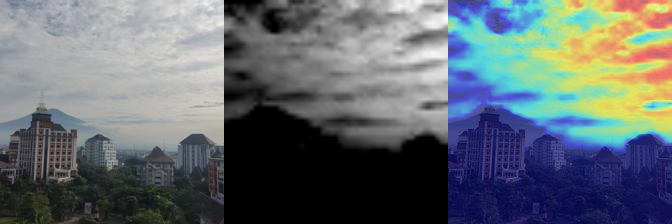

In [36]:
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
#model.load_state_dict(torch.load("E:\skripsi\koding skrip\hasil\model.pth"))
model.eval()
image_path = "E:\skripsi\koding skrip\hasil\data\Tidak Sehat Bagi Sebagian Orang\IMG_20240604_080931_TIMEBURST55.jpg"
img = Image.open(image_path)
img = np.array(img)
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(3)]
target_layers = [model.block2]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

INFERENCE

In [13]:
model.load_state_dict(torch.load("E:\skripsi\koding skrip\hasil\model.pth"))
model.eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_path = "E:\skripsi\koding skrip\hasil\data\Tidak Sehat\IMG_20240402_100934_164.jpg"
image = Image.open(image_path)
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)
input_batch = input_batch.to(device)
# Make prediction
with torch.no_grad():
    output = model(input_batch)

# Get predicted class
_, predicted_class = torch.max(output, 1)
print(f"Predicted class index: {predicted_class.item()}")

Predicted class index: 2
